In [31]:
# Import your libraries here
#import os
#import sqlite3
#from glob import glob

#import joblib
#import pandas as pd
#import requests
#from arch.univariate.base import ARCHModelResult
#from arch.univariate.base import ARCHModelResult
#from config import settings
#from data import SQLRepository


%load_ext autoreload
%load_ext sql
%autoreload 2

import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
import requests
# Import your libraries here
import os
from glob import glob
import joblib
from arch.univariate.base import ARCHModelResult
from config import settings
from data import SQLRepository
from config import settings

ModuleNotFoundError: No module named 'arch'

In [3]:
ticker = "MTNOY"
output_size = "full"
data_type = "json"

url = (
    "https://learn-api.wqu.edu/1/data-services/alpha-vantage/query?"
    "function=TIME_SERIES_DAILY&"
    f"symbol={ticker}&"
    f"outputsize={output_size}&"
    f"datatype={data_type}&"
    f"apikey={settings.alpha_api_key}"
);


print("url type:", type(url))
url

url type: <class 'str'>


'https://learn-api.wqu.edu/1/data-services/alpha-vantage/query?function=TIME_SERIES_DAILY&symbol=MTNOY&outputsize=full&datatype=json&apikey=bed66634865643bd2e290f6162ba4b4990bca09f4bc2ef639eebef153ae9942cf2737b2342657cb0083cc67ae16ef37bd6d1b8e6c1c67fe234551b1cb9f8bc776a27fcb20dfa8dcc416e6e188eb2cc157a05c7f11ad778444d62c9a0312a8f8f2664bcca76f3aac097f039c2440c15e135ded8c697264c427d352b7feab29898'

In [4]:
response = requests.get(url=url)

print("response type:", type(response))

response type: <class 'requests.models.Response'>


In [5]:
response_text = response.text

print("response_text type:", type(response_text))
print(response_text[:200])

response_text type: <class 'str'>
{
    "Meta Data": {
        "1. Information": "Daily Prices (open, high, low, close) and Volumes",
        "2. Symbol": "MTNOY",
        "3. Last Refreshed": "2023-03-10",
        "4. Output Size": "


In [6]:
response_code = response.status_code

print("code type:", type(response_code))
response_code

code type: <class 'int'>


200

In [8]:
stock_data = response.json()["Time Series (Daily)"]

In [9]:
df_mtnoy = pd.DataFrame.from_dict(stock_data,orient="index",dtype=float)

print("df_mtnoy type:", type(df_mtnoy))
df_mtnoy.head()

df_mtnoy type: <class 'pandas.core.frame.DataFrame'>


,1. open,2. high,3. low,4. close,5. volume
2023-03-10,7.76,7.76,7.70,7.705,27132.0
2023-03-09,7.70,7.77,7.67,7.710,7333.0
2023-03-08,7.78,7.88,7.74,7.880,9168.0
2023-03-07,7.97,7.97,7.75,7.830,3226.0
2023-03-06,7.92,8.12,7.92,7.970,5527.0


In [10]:
# Convert `df_ambuja` index to `DatetimeIndex`
df_mtnoy.index =pd.to_datetime(df_mtnoy.index)

# Name index "date"
df_mtnoy.index.name = "date"
df_mtnoy.columns = [c.split(". ")[1] for c in df_mtnoy.columns]
df_mtnoy.head()

,open,high,low,close,volume
date,,,,,
2023-03-10,7.76,7.76,7.70,7.705,27132.0
2023-03-09,7.70,7.77,7.67,7.710,7333.0
2023-03-08,7.78,7.88,7.74,7.880,9168.0
2023-03-07,7.97,7.97,7.75,7.830,3226.0
2023-03-06,7.92,8.12,7.92,7.970,5527.0


In [11]:
connection =sqlite3.connect(database=settings.db_name,check_same_thread=False)
connection

In [12]:
# Insert `MTNOY` data into database
# Import class definition
from data import SQLRepository
# Create instance of class
repo = SQLRepository(connection=connection)
response = repo.insert_table(table_name=ticker, records=df_mtnoy, if_exists="replace")

In [13]:
sql = "SELECT * FROM 'MTNOY'"
df_mtnoy_read = pd.read_sql(
    sql=sql,con=connection,parse_dates=["date"], index_col="date"
)

print("df_mtnoy_read type:", type(df_mtnoy_read))
print("df_mtnoy_read shape:", df_mtnoy_read.shape)
df_mtnoy_read.head()

df_mtnoy_read type: <class 'pandas.core.frame.DataFrame'>
df_mtnoy_read shape: (3943, 5)


,open,high,low,close,volume
date,,,,,
2023-03-10,7.76,7.76,7.70,7.705,27132.0
2023-03-09,7.70,7.77,7.67,7.710,7333.0
2023-03-08,7.78,7.88,7.74,7.880,9168.0
2023-03-07,7.97,7.97,7.75,7.830,3226.0
2023-03-06,7.92,8.12,7.92,7.970,5527.0


In [14]:
df_mtnoy = repo.read_table(table_name="MTNOY", limit=2500 +1)

# Sort DataFrame ascending by date
df_mtnoy.sort_index(ascending=True,inplace=True)

# Create "return" column
df_mtnoy["return"] = df_mtnoy["close"].pct_change() *100
#Series return column
y_mtnoy = df_mtnoy["return"].dropna()

print("y_mtnoy type:", type(y_mtnoy))
print("y_mtnoy shape:", y_mtnoy.shape)
y_mtnoy.head()

y_mtnoy type: <class 'pandas.core.series.Series'>
y_mtnoy shape: (2500,)


date
2013-04-08    1.359773
2013-04-09    0.614869
2013-04-10    3.033333
2013-04-11   -0.733312
2013-04-12   -2.335687
Name: return, dtype: float64

In [15]:
mtnoy_daily_volatility = y_mtnoy.std()

print("mtnoy_daily_volatility type:", type(mtnoy_daily_volatility))
print("MTN Daily Volatility:", mtnoy_daily_volatility)

mtnoy_daily_volatility type: <class 'float'>
MTN Daily Volatility: 2.9127894518524107


In [16]:
import numpy as np
mtnoy_annual_volatility = mtnoy_daily_volatility * np.sqrt(252)

print("mtnoy_annual_volatility type:", type(mtnoy_annual_volatility))
print("MTN Annual Volatility:", mtnoy_annual_volatility)

mtnoy_annual_volatility type: <class 'numpy.float64'>
MTN Annual Volatility: 46.23909906656176


Text(0.5, 1.0, 'Time Series of MTNOY Returns')

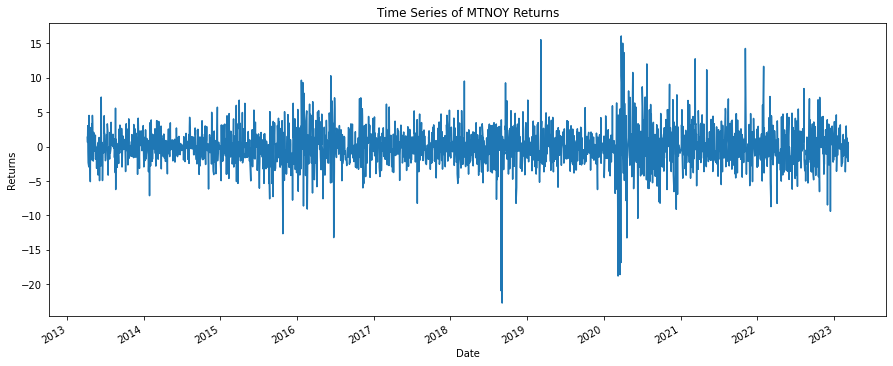

In [17]:
import matplotlib.pyplot as plt
# Create `fig` and `ax`
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_mtnoy` on `ax`
y_mtnoy.plot(ax=ax)

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Returns")


# Add title
plt.title("Time Series of MTNOY Returns")


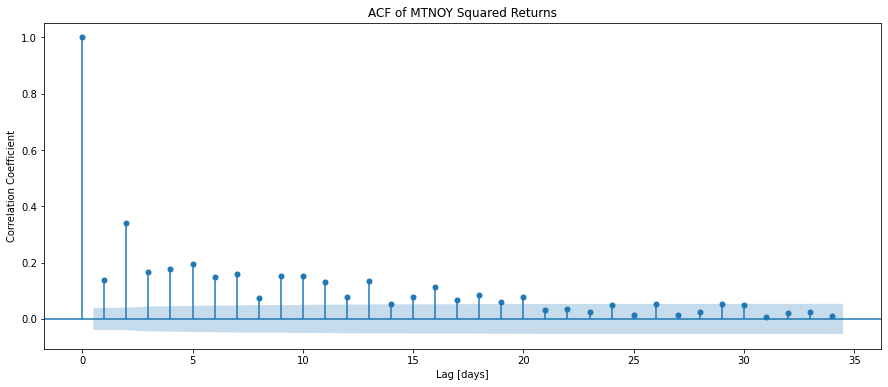

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Create `fig` and `ax`
fig,ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y_mtnoy**2,ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")


# Add title
plt.title("ACF of MTNOY Squared Returns");

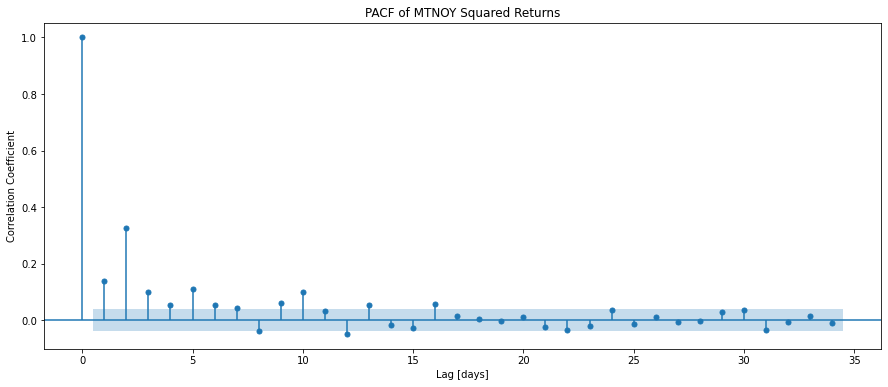

In [19]:
# Create `fig` and `ax`
fig,ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_pacf(y_mtnoy**2,ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient")


# Add title
plt.title("PACF of MTNOY Squared Returns");

In [20]:
cutoff_test = int((len(y_mtnoy) *0.8))
y_mtnoy_train = y_mtnoy.iloc[:cutoff_test]

print("y_mtnoy_train type:", type(y_mtnoy_train))
print("y_mtnoy_train shape:", y_mtnoy_train.shape)
y_mtnoy_train.head()

y_mtnoy_train type: <class 'pandas.core.series.Series'>
y_mtnoy_train shape: (2000,)


date
2013-04-08    1.359773
2013-04-09    0.614869
2013-04-10    3.033333
2013-04-11   -0.733312
2013-04-12   -2.335687
Name: return, dtype: float64

In [21]:
from arch import arch_model
# Build and train model
model = arch_model(y_mtnoy_train,p=1,q=1,rescale=False).fit(disp=0)

print("model type:", type(model))

# Show model summary
model.summary()

ModuleNotFoundError: No module named 'arch'

In [22]:
from arch import arch_model
# Build and train model
model = arch_model(y_mtnoy_train,p=1,q=1,rescale=False).fit(disp=0)

print("model type:", type(model))

# Show model summary
model.summary()

ModuleNotFoundError: No module named 'arch'

NameError: name 'model' is not defined

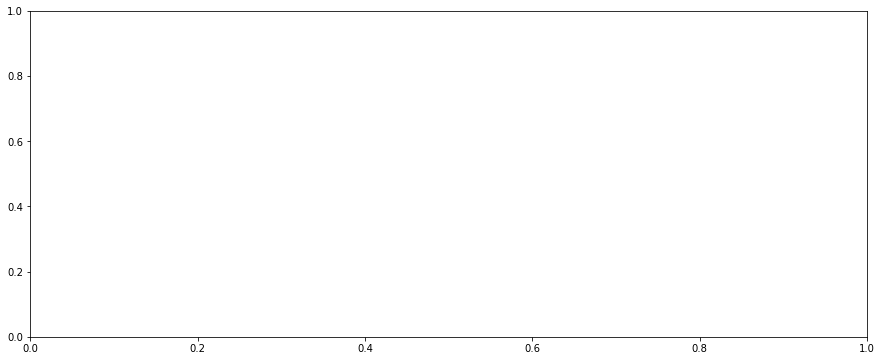

In [23]:
# Create `fig` and `ax`
fig, ax =plt.subplots(figsize=(15,6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2,ax=ax)

# Add axis labels
plt.xlabel("Correlation Coefficient")
plt.ylabel("Lag [days]")


# Add title
plt.title("ACF of MTNOY GARCH Model Standardized Residuals")

NameError: name 'model' is not defined

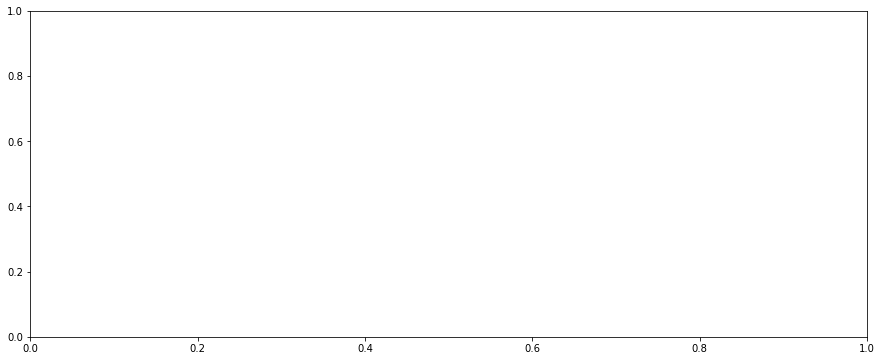

In [24]:
# Create `fig` and `ax`
fig, ax =plt.subplots(figsize=(15,6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2,ax=ax)

# Add axis labels
plt.xlabel("Correlation Coefficient")
plt.ylabel("Lag [days]")


# Add title
plt.title("ACF of MTNOY GARCH Model Standardized Residuals")

In [25]:
# Import `FitIn` class and `fit_model` function
from main import FitIn, fit_model

# Instantiate `FitIn` object
request = FitIn(ticker="MTNOY", use_new_data=False, n_observations=2500, p=1, q=1)

# Build model and fit to data, following parameters in `request`
fit_out = fit_model(request=request)

# Inspect `fit_out`
fit_out

ImportError: cannot import name 'FitIn' from 'main' (C:\Users\Med's PC\Desktop\Data Retrival\main.py)

In [26]:
# URL of `/fit` path
url = "http://localhost:8008/fit"
# Data to send to path
json = {
    "ticker":"MTNOY",
    "use_new_data": True,
    "n_observations":2500,
    "p":1,
    "q":1
}

# Response of post request
response = requests.post(url=url,json=json)

print("response type:", type(response))
print("response status code:", response.status_code)

ConnectionError: HTTPConnectionPool(host='localhost', port=8008): Max retries exceeded with url: /fit (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001DAD2D0E790>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))

In [27]:
# URL of `/predict` path
url = "http://localhost:8008/predict"
# Data to send to path
json = {
    "ticker": "MTNOY",
    "n_days": 5
}
# Response of post request
response = requests.post(url=url,json=json)

print("response type:", type(response))
print("response status code:", response.status_code)

ConnectionError: HTTPConnectionPool(host='localhost', port=8008): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001DAD2C8AB80>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))